In [1]:
import numpy as np
from utils import pca, reconstruction, normalized
import os
import cv2 as cv
import math
import random
import pandas as pd
from scipy.spatial import distance

## Preprocessing

In [2]:
dataset_dir = './dataset'
test_ratio = 0.2

In [3]:
# each key in these dicts maps to a class ndarray.
# a class ndarray holds all images for a specefic class.
train_dict, test_dict = (dict(), dict())

# we are considering each folder name as a class label
for class_label in os.listdir(dataset_dir):
  # ignore irrelevant folders.
  # (we only consider folders named like: 'xx' where x is a digit).
  if(len([x for x in class_label if x.isdigit()]) != 2):
    continue

  images = list()
  for i, img_name in enumerate(os.listdir(os.path.join(dataset_dir, class_label))):
    img_path = os.path.join(dataset_dir, class_label, img_name)

    # the next 2 lines convert the image to grayscale
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    # _, b_image = cv.threshold(image, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    b_image = image
    
    # add the image
    images.append(b_image)
  
  # split to train and test according to the set test_ratio. Then convert to numpy ndarrays
  n_test_samples = math.floor(test_ratio * len(images))
  random.shuffle(images)
  test_dict[class_label] = np.array(images[:n_test_samples], dtype=np.float64)
  train_dict[class_label] = np.array(images[n_test_samples:], dtype=np.float64)

## Constructing PCA Matrix

We will construct a PCA matrix for each class and store them in a dictionary. Each key is a class label and maps to the corresponding matrix

In [4]:
n_components = {
  '01': 50,
  '02': 80,
  '04': 50,
  '06': 100,
  '08': 150,
  '09': 100
}

In [5]:
pca_by_class = dict()
for class_label in train_dict:
  images = train_dict[class_label]
  n_samples, h, w = images.shape
  pca_by_class[class_label] = pca(images.reshape(n_samples, h*w), n_components[class_label])

# Testing

{'08': 0.75, '06': 1.0, '09': 1.0, '02': 0.8947368421052632, '04': 0.8421052631578947, '01': 0.631578947368421}
class:  08
['08: 0.2672173595653771', '06: 0.31482721003637054', '09: 0.29294565266481915', '02: 0.2969378051199491', '04: 0.2767618118995022', '01: 0.2812608848549093']
class:  06
['08: 0.29910397857265547', '06: 0.27034234100438825', '09: 0.32115116297085394', '02: 0.29279199887287016', '04: 0.2965668508281175', '01: 0.3069854925547727']
class:  09
['08: 0.655662214345359', '06: 0.6668622231904588', '09: 0.49972297051957437', '02: 0.6880098740173546', '04: 0.6437554404500438', '01: 0.6766828365313216']
class:  02
['08: 0.20836855440011864', '06: 0.19552071574343913', '09: 0.25170191613548704', '02: 0.18461931089516825', '04: 0.20714975716577044', '01: 0.21144431946989375']
class:  04
['08: 0.2093476372712041', '06: 0.229811072841603', '09: 0.23228639651819696', '02: 0.23053516524275444', '04: 0.195950711042965', '01: 0.2118144779002085']
class:  01
['08: 0.17681385263868177

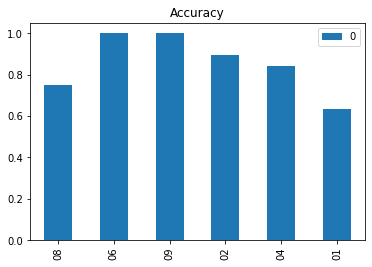

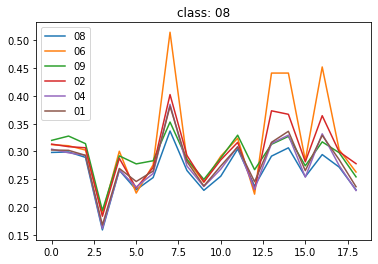

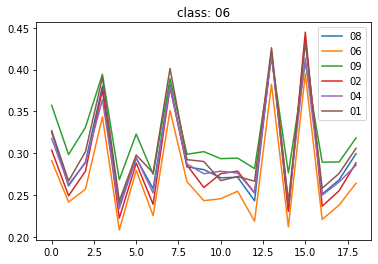

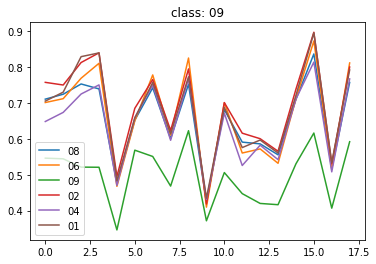

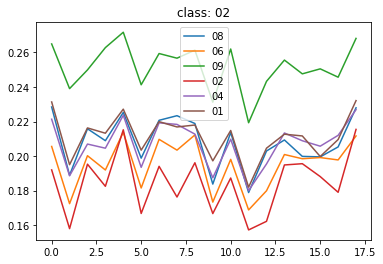

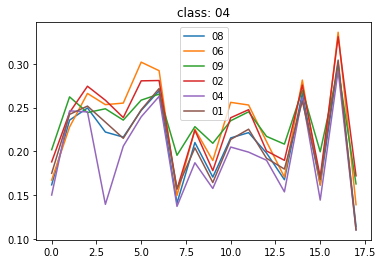

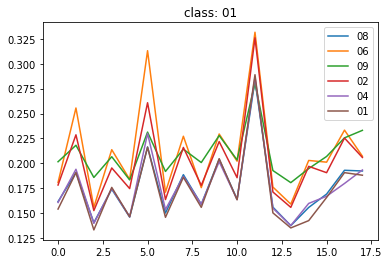

In [6]:
# this dict will hold the accuracy for each class.
accuracy = dict()
# this will hold distance between each class and other classes.
class_distance = dict()

for true_class_label in test_dict:
  images = test_dict[true_class_label]
  n_samples, h, w = images.shape
  X = images.reshape(n_samples, h*w)
  class_distance[true_class_label] = dict()
  
  hits = 0
  for i in range(n_samples):
    distances = []
    class_labels = []
    for class_label in pca_by_class:
      C, M, _ = pca_by_class[class_label]
      recovered_image = reconstruction(X - M, C, M, h, w, i)
      dist = distance.euclidean(normalized(images[i].reshape(h*w)), normalized(recovered_image.reshape(h*w)))
      distances.append(dist)
      class_labels.append(class_label)
      if (class_label in class_distance[true_class_label]):
        class_distance[true_class_label][class_label].append(dist)
      else:
        class_distance[true_class_label][class_label] = []
    
    predicted_class_label = class_labels[np.argmin(distances)]
    if(predicted_class_label == true_class_label):
      hits += 1
  accuracy[true_class_label] = hits / n_samples

print(accuracy)
accuracy_df = pd.DataFrame(data=accuracy.values(), index=accuracy.keys())
accuracy_df.plot(title='Accuracy', kind='bar')

for k in class_distance:
  print('class: ', k)
  print([f'{sk}: {np.mean(class_distance[k][sk])}' for sk in class_distance[k]])
  distances_df = pd.DataFrame(data=class_distance[k])
  distances_df.plot(title=f'class: {k}')